# Generative models through autoencoders



Los pasos para generar objetos nuevos son

1. Tomar datos de objetos del tipo que se quiere generar. Por ejemplo, si quiere generar caracteres de numeros a mano, el MNIST es una buena base de datos.

2. Entrene con esos datos: musica, texto, poesia.

3. Corta la red una vez entrenada. Se queda con la primera mitad.

4. Sample points in the latent space. Haga un muestreo en el espacio latente.

5. Usa los pesos aprendidos en el paso  2 para crear nuevos objetos: digitos, musica, poesia.

## Ejemplos que de cosas que se pueden hacer con autoencoders.

La clase anterior vimos dos aplicaciones de **autoencoders**
Reduccion de dimensionalidad no lineal.
1. Reducir de $128 \times 128$ a 32 dimensiones
2. Reducir de $128 \times 128$ a 2 dimensiones.

Hoy veremos otras dos aplicaciones

1. Eliminacion de ruido (denoising)
2. Deteccion de anomalias.

### Eliminacion de ruido:
Esta tecnica no necesita regularizacion por que el ruido mismo sirve para regularizar. El proceso necesita un entrenamiento de la siguiente forma.

* Se agrega ruido a los objetos.
* Como conocemos el resultado de deseado $\hat{x}$ (sin ruido)
Definimos una funcion de costo

$$J(\theta) = \| x - \hat{x} \|^2 $$
Los datos "encoded" (coded, espacio latente, el cuello de botella) son
$f(x + N)$ donde $N$ es el ruido y $f$ es la funcion que codifica los datos.
La decodificacion se obtiene matematicamente mediante

$$\hat{x} = g( f( x + N) $$
donde $g$ es el decodificador.

Veamos un ejemplo en `Python` usando el MNIST.
En vez de MLP usamos CCN.


In [13]:
# removing noise with autoencoders
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.layers import Input, Dense
from keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.utils import plot_model

In [14]:
# a seed for reproducibility
np.random.seed(42)

# load the MNIST dataset
(x_train, _), (x_test, _) = mnist.load_data()

# normalize data
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255

# reshape data o include channels dimension
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

# add random noise
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

# clip the values to be between 0 and 1
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)





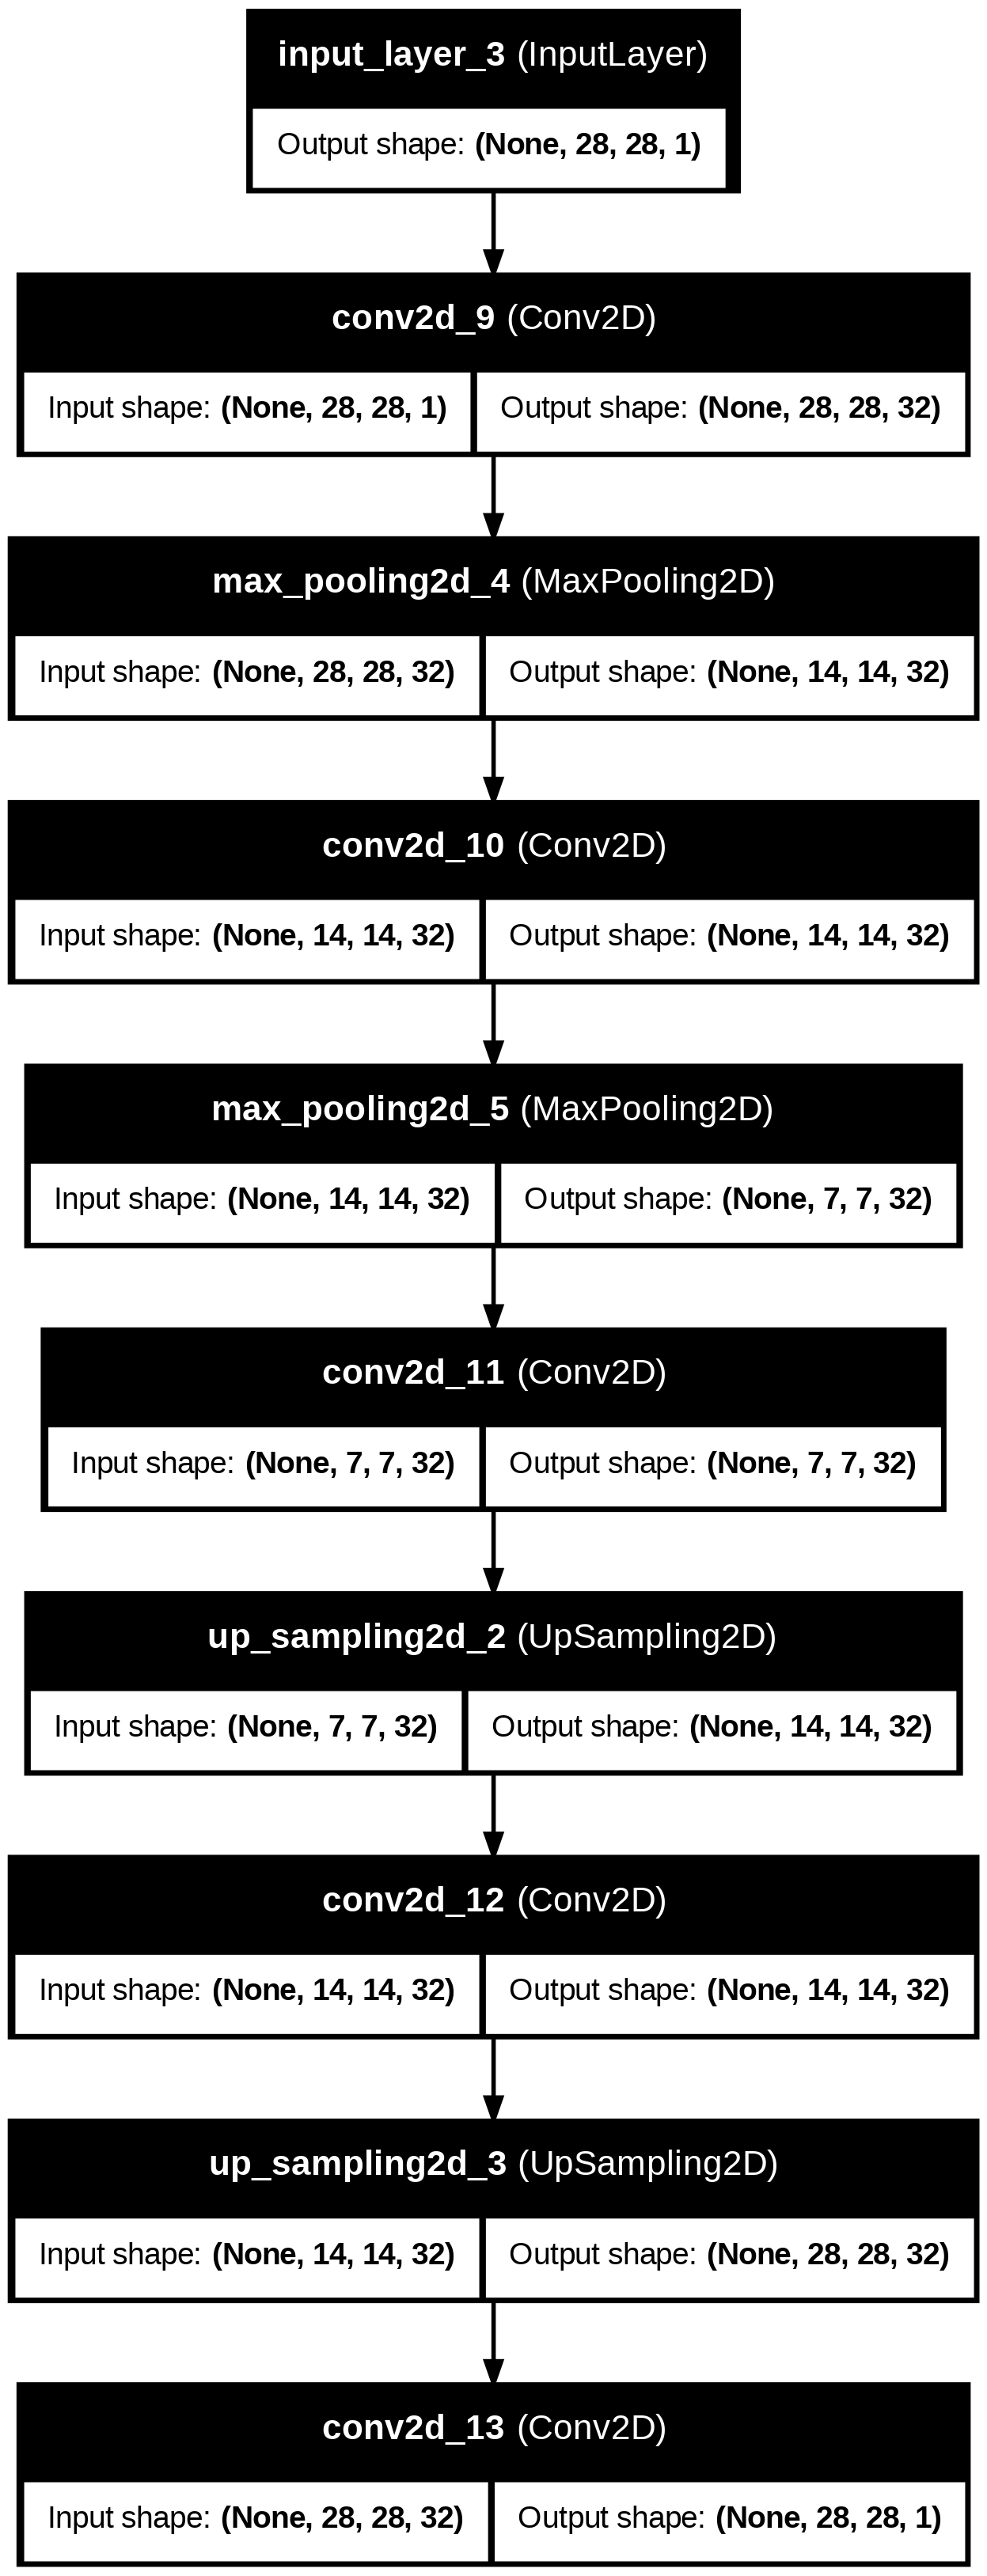

In [15]:
# define the autoencoder
input_img = Input(shape=(28, 28, 1))

# create two convolutional layers with MaxPooling
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)


# define the decoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)

decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# create the autoencoder model
autoencoder = Model(input_img, decoded)

# compile the model
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# finalizamos esta parte graficando la arquitectura
plot_model(autoencoder, to_file='autoencoder.png', show_shapes=True, show_layer_names=True)


Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 134s 286ms/step - loss: 0.1319 - val_loss: 0.1134
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 138s 277ms/step - loss: 0.1123 - val_loss: 0.1067
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 141s 276ms/step - loss: 0.1072 - val_loss: 0.1043
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 151s 295ms/step - loss: 0.1044 - val_loss: 0.1029
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 135s 281ms/step - loss: 0.1027 - val_loss: 0.1007
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 153s 305ms/step - loss: 0.1016 - val_loss: 0.0999
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 189s 278ms/step - loss: 0.1006 - val_loss: 0.0989
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 146s 286ms/step - loss: 0.0997 - val_loss: 0.0983
Epoch 9/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 140s 281ms/step - loss: 0.0993 - val_loss: 0.0979
Epoch 10/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 150s 299ms/step - loss: 0.0985 - val_loss: 0.0973
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━

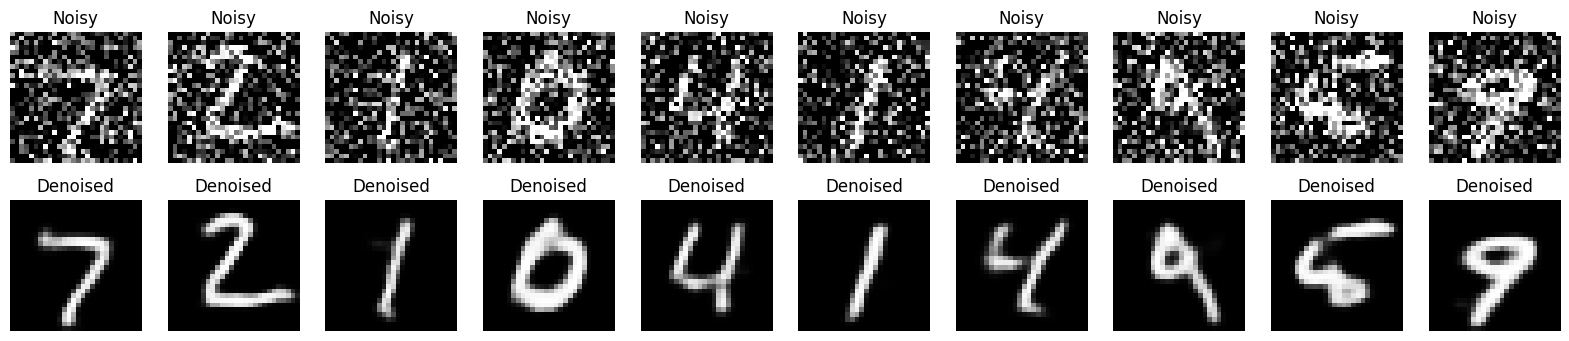

In [17]:
# train the model
autoencoder.fit(x_train_noisy, x_train,
                epochs=10,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

# predict the denoised images
n=10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display the original noisy images
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    plt.title("Noisy")
    plt.axis('off')

    # display the denoised image
    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(autoencoder.predict(x_test_noisy[i].reshape(1, 28, 28, 1))[0].reshape(28, 28))
    plt.gray()
    plt.title("Denoised")
    plt.axis('off')
plt.show()

### Deteccion de anomalias con autoencoders.
La idea es que se tienen datos buenos pero hay "outliers" (muestras por fuera de lo normal).

Recomiendo
[Blog de deteccion de anomalias con auto-encoders](https://www.kaggle.com/code/robinteuwens/anomaly-detection-with-auto-encoders).

Otro sitio interesante es:

[ Desmitificando redes neuronales: deteccion de anomalias con AutoEncoders](https://medium.com/@weidagang/demystifying-anomaly-detection-with-autoencoder-neural-networks-1e235840d879).

Un punto interesante de ese ultimo enlace es que usa MLP (Multilayer Perceptron).

Vamos a hacer el siguiente ejercicio en Python.
Usamos el MNIST, tomamos el 0 como una muestra normal y todos los demas como muestras anomalas.



In [18]:
# deteccion de anomalias con autoencoders
# import libraries
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D

# definir semilla
np.random.seed(42)

In [22]:
# load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# normalize
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# reshape
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

# use '0' como un digito normal. Los demas son anomalias.

x_train_normal = x_train[y_train == 0]
# Use square brackets for boolean indexing
x_test_normal = x_test[y_test == 0]

# usar los otros digitos como anomalias
x_test_anomalies = x_test[y_test != 0]


In [28]:
# definamos el encoder
input_img = Input(shape=(28, 28, 1))

# create two convolutional layers with MaxPooling2D
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# define the decoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
# define the autoencoder model
autoencoder = Model(input_img, decoded)

# compile the model
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')



In [38]:
# train the model
autoencoder.fit(x_train_normal, x_train_normal,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_split=0.2)

Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 269ms/step - loss: 0.0902 - val_loss: 0.0937
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 238ms/step - loss: 0.0910 - val_loss: 0.0890
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 242ms/step - loss: 0.0892 - val_loss: 0.0898
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 270ms/step - loss: 0.0895 - val_loss: 0.0885
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 266ms/step - loss: 0.0886 - val_loss: 0.0878
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 269ms/step - loss: 0.0880 - val_loss: 0.0874
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 235ms/step - loss: 0.0876 - val_loss: 0.0889
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 11s 241ms/step - loss: 0.0876 - val_loss: 0.0883
Epoch 9/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 11s 266ms/step - loss: 0.0874 - val_loss: 0.0867
Epoch 10/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 263ms/step - loss: 0.0863 - val_loss: 0.0861
Epoch 11/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 266ms/step - loss: 0.0860 - val_loss: 0.0858
Epoch 12/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
282/282 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step


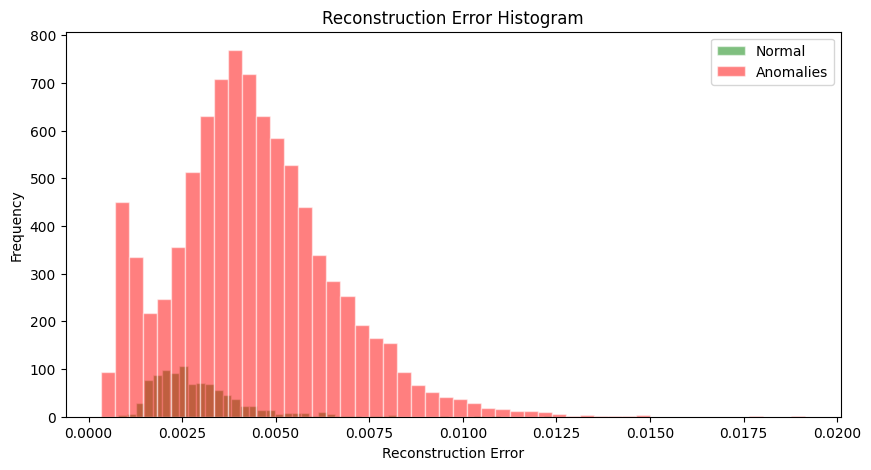

Threshold:  0.0067520337
Number of anomalies detected: 1160 out of 9020


In [46]:
# evaluacion para detectar anomalias
decoded_normal = autoencoder.predict(x_test_normal)
decoded_anomalies = autoencoder.predict(x_test_anomalies)

# construct reconstruction error
mse_normal = np.mean(np.square(x_test_normal - decoded_normal), axis=(1, 2,3))
mse_anomalies = np.mean(np.square(x_test_anomalies - decoded_anomalies), axis=(1, 2,3))

# fig, ax = plt.subplots(figsize=(10, 5))
fig, ax = plt.subplots(figsize=(10, 5))

# plot the histograms
# Access the first Axes object using ax[0]
ax.hist(mse_normal, bins=50, alpha=0.5, label='Normal', color='g', edgecolor='w' )
# Access the second Axes object using ax[1] and plot the second histogram
ax.hist(mse_anomalies, bins=50, alpha=0.5, label='Anomalies', color='r', edgecolor='w') # Changed color to differentiate


plt.legend()
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.title('Reconstruction Error Histogram')
plt.show()

# muestre el umbral  y el numero de anomalias
threshold = np.mean(mse_normal) + 3*np.std(mse_normal)
anomalies = mse_anomalies > threshold
print('Threshold: ', threshold)
print(f"Number of anomalies detected: {np.sum(anomalies)} out of {len(mse_anomalies)}")



# Variational Auto-encoders (Autoencoders variacionales)

## Historia:
El articulo original fue escrito por Kingma and Welling

 Diederik P. Kingma and Max Welling.
 Auto-Encoding Variational Bayes, 2014.
https://arxiv.org/abs/1312.6114.


Es del 2014. Hay unas explicaciones mas claras en

Diederik P. Kingma and Max Welling. An introduction to variational autoencoders.
Foundations and Trends® in Machine Learning, 12(4):307–392, 2019.

## Motivacion.
Los auto-encoders tiene ciertan limitaciones.

1. El espacio latente no es simetrico.  A que me refiero con esto?


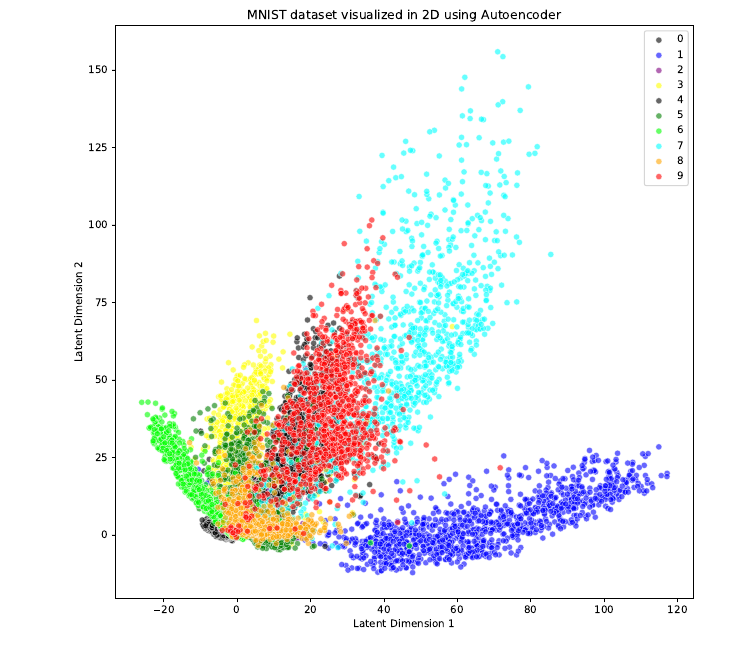

La Figura anterior es el espacio latente del MNIST en 2D.  No es simetrico con respecto al origen. Este grafico se genero con autoencoders. Si en vez de autoencoders usamos Variational Autoencoders obtenemos la siguiente Figura.


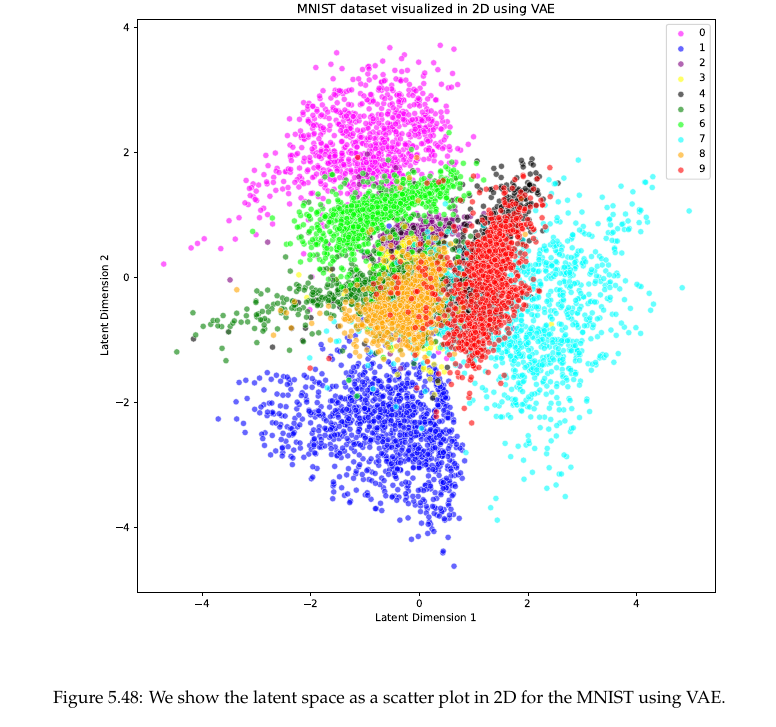

La simetria es importante por que el metodo de VAE (Variational Auto-encoders) se basa en estadistica. Y se va muestrear basado en una distribucion normal, la cual es simetrica.

2.Otro problema del Auto-encoders son los huecos grandes. La generacion de datos nuevos se hace con un muestreo en el espacio latente. La Figura 5.48 esta mas uniformente distribuida en el espacio. Sin embargo la Figura generada por Auto-encoders tiene huecos. Que problema tienen esos huecos?

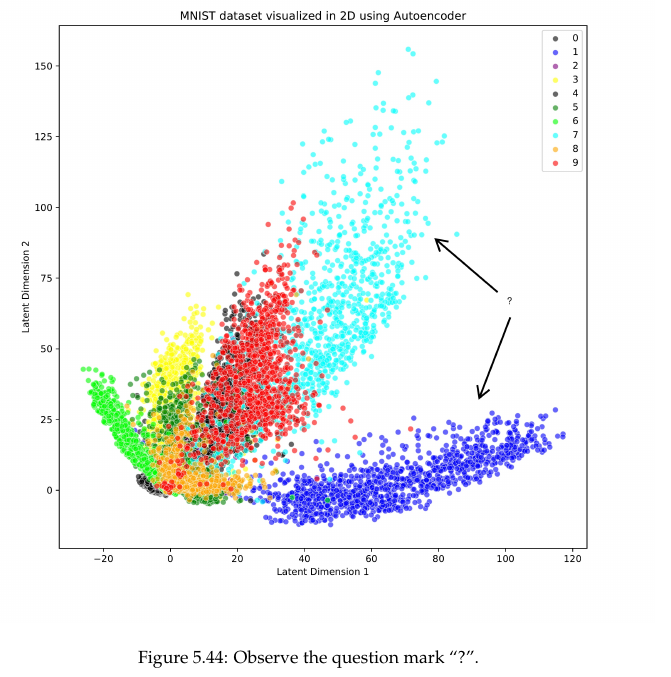

3. Los datos en el espacio latente estan en areas muy pequenhas en unas partes y grandes en otras en los autoencoders, mientras que en los VAE

La idea detras de los VAE es que usa metodos de Bayes, esta dentro del tema de BML (Bayesian Machine Lerning). Hay varias citas importantes.

Kevin P. Murphy. Machine Learning: A Probabilistic Perspective. MIT Press, Cambridge,
MA, USA, 2012.

[Jeremy Jordan](https://www.jeremyjordan.me/variational-autoencoders/)
hace una presentacion (blog) bastante ilustrativa acerca del metodo.



Vamos a ver en un diagrama como es el algoritmo y comenzamos a desarrollar la matematica del modelo.




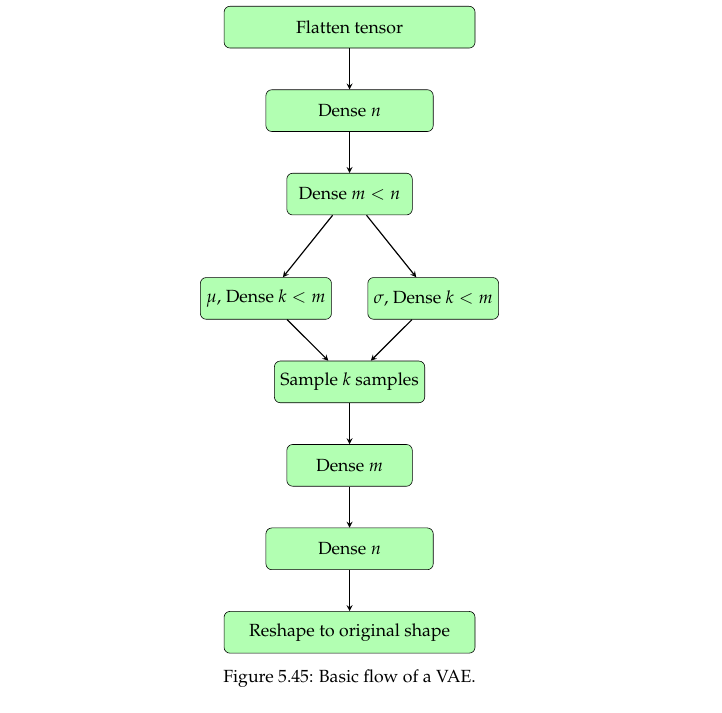

La ultima figura antes de irnos a la matematica del modelo es una figura que compara un punto en el espacio latente de los autoencoders, con la nube en el espacio latente de los VAE.

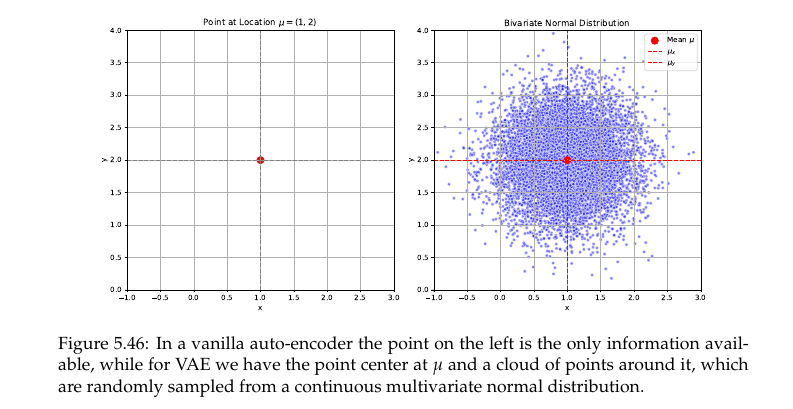

Como es un metodo de redes neuronales debemos construir una funcion de costo a la cual le debemos calcular el gradiente y hacer descenso con gradiente, como lo hemos hecho todo el tiempo.

La funcion de costo se basa en las siguientes dos partes.

1. Debemos reconstruir la salida tan cerca como sea posible a la entrada.
2. Existe una metrica llamada
[Kullback-Leibler (KL)](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence)
que mide "la distancia" entre dos densidades de probabilidad.

Queremos ver problema como un problema de optimizacion, donde debemos encontrar una funcion de costo $J(\theta)$.  Asumimos un conjunto de datos

$$\{ x_1, x_2, \cdots, x_m \} $$
Estos generan una variable **latent** (latente) es $z$. El proceso envuelve 2 pasos

1. Se debe muestrear (sample) la variable latente $z$ de una distribucion de
probabilidad (density distribution) a priori $p(z)$. Usualmente es una distribucion normal standard (Gaussiana).

2. Generamos $x$ (la muestra generada) con una distribucion condicional $p(x | z)$

La meta seria maximizar la probabilidad marginal de los datos $X$, es decir $p(X)$. Esta analiticamente se escribe como

$$p_{\theta}(x) = \int p_{\theta}(x, z) dz \tag{1} $$.
Esto es lo que queremos maximizar. Esta expresion es "intractable". Casi imposible de calcular. Por que?

* El espacio latente, donde vive $z$ es en general de altas dimensiones.
* En general la integral no es analittica, no-lineal y muy complicada.
Pero la Ecuacion (1) es el punto de partida para llegar a la funcion de costo.

Transformamos la Ecuacion (1) mediante  el logaritmo de la siguiente forma.

$$\log p_{\theta}(x) = \log \int p_{\theta}(x,z) dz  = \log \int \frac{p_\theta(x,z)}{q_\phi(z | x)}  q_\phi (z | x ) dz $$

Existe una desigualdad llamada la
[desigualdad de Jensen](https://en.wikipedia.org/wiki/Jensen%27s_inequality)
la dice que: Si $f$ es una funcion **convexa** entonces

$$f(\mathbb{E}[X]) \le \mathbb{E}[ f(X)]. $$

En nuestro caso, $\log$ es concava, pero entonces $-\log$ es convexa

$$-\log \mathbb{E}_{q_\phi(z | x)} \left [ \frac{p_{\theta}(x,z)}{q_\phi(z | x)}  \right ]  \le - \mathbb{E}_{q_\phi(z | x)} \log
\left [ \frac{p_{\theta}(x, z)}{q_\phi(z | x)}  \right ] $$
Podemos multiplicar por $-1$

$$\log \mathbb{E}_{q_\phi(z | x)} \left [ \frac{p_{\theta}(x,z)}{q_\phi(z | x)}  \right ]  \ge  \mathbb{E}_{q_\phi(z | x)} \log
\left [ \frac{p_{\theta}(x, z)}{q_\phi(z | x)}  \right ] \tag{2} $$

Esta expresion es muy importante en el medio estadistico. Se llama ELBO: **Evidence of Lower Bound**.


 [ELBO](https://en.wikipedia.org/wiki/Evidence_lower_bound).

En este momento ya podemos pensar en un problema de optimizacion.
La expresion de la izquierda de (2) es lo que queremos obtener, pero es muy dificil. La de derecha esta siempre por debajo, entonces la idea es **maximizar** la expresion de la derecha. Pero maximizar la expresion de la derecha es lo mismo que **minimizar** su negativo.  Es decir queremos
minimizar la siguiente funcion de costo

$$C(\theta, \phi, x) =  \mathbb{E}_{q_\phi(z | x)} \log
\left [ \frac{q_\phi(z | x)}{p_\theta(x, z)} \right ]  $$

De la propiedad "regla la cadena para probabilidades" tenemos que
$$p_\theta(x, z) = p_\theta(x | z) p(z) . $$

Entonces, applicando las propiedades del logaritmo y esta ultima propiedad de la regla de la cadena para probabilidades encontramos

\begin{eqnarray}
C(\theta, \phi, x) &=& \mathbb{E}_{q_\phi(z | x)} [ \log q_\phi(z | x)] -
\mathbb{E}_{q_\phi(z | x)} [ \log p_\theta(x | z) ] - \mathbb{E}_{q_\phi(z | x)} [ \log p(z)] \\
&=& -
\mathbb{E}_{q_\phi(z | x)} [ \log p_\theta(x | z) ] +
\mathbb{E}_{q_\phi(z | x)} \log \frac{q_\phi(z | x)}{p(z)} \\
&=& \underbrace{-\mathbb{E}_{q_\phi(z | x)} [ \log p_\theta(x | z) ]}_{\text{reconstruccion}} +  \underbrace{D_{KL} (q_\phi(z | x) \parallel  p(z) )}_{\text{ LK divergence}}.
\end{eqnarray}

